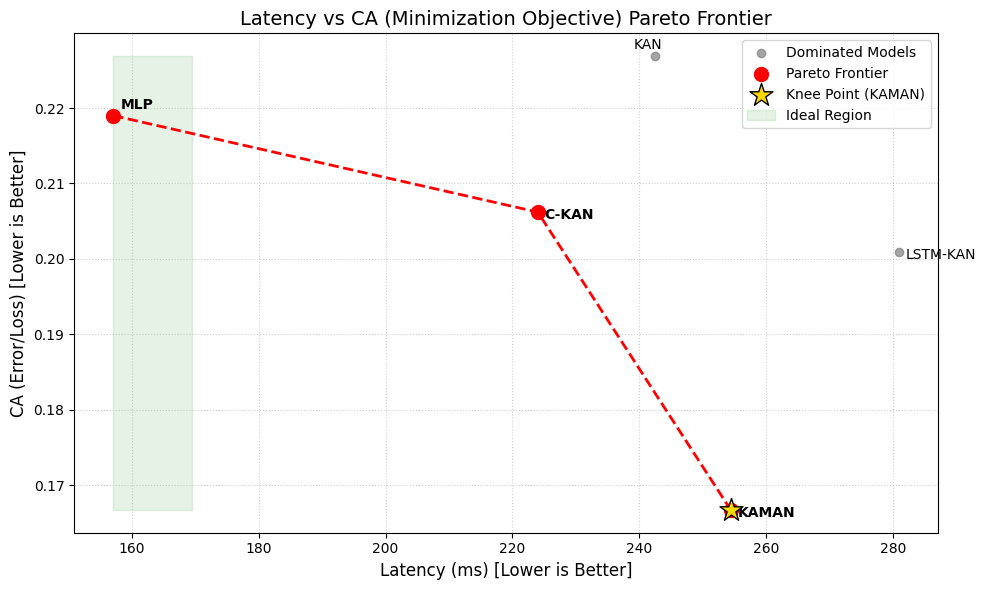

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Your Data
data = {
    'Model': ['MLP', 'KAN', 'C-KAN', 'LSTM-KAN', 'KAMAN'],
    # CA (Classification Error/Loss) - Minimize (Y-axis)
    'CA': np.array([0.2190, 0.2269, 0.2062, 0.2009, 0.1667]),
    # Latency_ms (Latency) - Minimize (X-axis)
    'Latency_ms': np.array([157.06, 242.47, 224.01, 280.92, 254.46]),
}

models = data['Model']
latency = data['Latency_ms']
ca = data['CA']

# 1. Identify Pareto Frontier (Minimization-Minimization)
is_pareto = np.ones(len(latency), dtype=bool)
for i in range(len(latency)):
    for j in range(len(latency)):
        if i != j:
            # Check if j dominates i
            dominates = (latency[j] <= latency[i] and ca[j] <= ca[i]) and \
                        (latency[j] < latency[i] or ca[j] < ca[i])
            
            if dominates:
                is_pareto[i] = False
                break

# Extract Pareto Frontier points
pareto_front_x = latency[is_pareto]
pareto_front_y = ca[is_pareto]
pareto_models = np.array(models)[is_pareto]

# Sort by Latency
sort_indices = np.argsort(pareto_front_x)
pareto_front_x = pareto_front_x[sort_indices]
pareto_front_y = pareto_front_y[sort_indices]
pareto_models = pareto_models[sort_indices]

# 2. Find Knee Point (Closest to the origin (0, 0))
l_min, l_max = latency.min(), latency.max()
c_min, c_max = ca.min(), ca.max()

best_dist = float('inf')
knee_point = (0, 0)
knee_model = ""

for x, y, model in zip(pareto_front_x, pareto_front_y, pareto_models):
    # Normalize Latency and CA to [0, 1] range
    norm_l = (x - l_min) / (l_max - l_min)
    norm_c = (y - c_min) / (c_max - c_min)
    
    # Calculate Euclidean distance to the ideal point (0, 0)
    dist = np.sqrt(norm_l**2 + norm_c**2)
    
    if dist < best_dist:
        best_dist = dist
        knee_point = (x, y)
        knee_model = model

# 3. Plotting
plt.figure(figsize=(10, 6))

# Plot all models
plt.scatter(latency, ca, color='gray', alpha=0.7, label='Dominated Models', zorder=5)

# Plot Pareto Frontier line and points
plt.plot(pareto_front_x, pareto_front_y, color='red', linewidth=2, linestyle='--', zorder=8)
plt.scatter(pareto_front_x, pareto_front_y, color='red', s=100, label='Pareto Frontier', zorder=9)

# Plot Knee Point
plt.scatter(knee_point[0], knee_point[1], color='gold', marker='*', s=300, edgecolors='black', label=f'Knee Point ({knee_model})', zorder=10)

# Annotate model names
for i, model in enumerate(models):
    text_offset = (5, 5) if model == 'MLP' else (-5, 5) if model == 'KAN' else (5, -5)
    
    plt.annotate(model, 
                 (latency[i], ca[i]), 
                 textcoords="offset points", 
                 xytext=text_offset, 
                 ha='center' if i==1 else 'left', 
                 fontsize=10,
                 fontweight='bold' if model in pareto_models else 'normal')

# Decorate the chart
plt.title('Latency vs CA (Minimization Objective) Pareto Frontier', fontsize=14)
plt.xlabel('Latency (ms) [Lower is Better]', fontsize=12)
plt.ylabel('CA (Error/Loss) [Lower is Better]', fontsize=12)

# Highlight Ideal Region
plt.fill_between([l_min, l_min + (l_max - l_min)*0.1], [c_min, c_min], [c_max, c_max], color='green', alpha=0.1, label='Ideal Region')
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()